S&P500 stock data:
http://pages.swcp.com/stocks/


n = pd.read_csv('http://chart.finance.yahoo.com/table.csv?s=ACIU&a=7&b=9&c=1996&d=10&e=19&f=2016&g=d&ignore=.csv')

http://www.eoddata.com/download.aspx

In [703]:
from sqlalchemy.orm import sessionmaker
from sqlalchemy import Table
from sqlalchemy import create_engine, inspect
from sqlalchemy import MetaData
from edgerdb import helper_functions as hlp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import requests
from yahoo_finance import Share
from pprint import pprint


meta = MetaData()

engine = create_engine('postgresql://analyst:@localhost:5432/edgar')

messages = Table('filings', meta, autoload=True, autoload_with=engine)

def sql_to_df(query, connection, *args, **kwargs):
    df = pd.read_sql(query, connection, *args, **kwargs)
    connection.close()
    return df

In [704]:
%matplotlib inline

<h2>Load table containing cik_symbol matches from database</h2>

In [2]:
cik_and_tickers = sql_to_df('select * from temp_cik_to_ticker;', engine.connect()).set_index(keys='index')

In [3]:
cik_and_tickers.head()

,cik,company_name,exchange,isactive,symbol
index,,,,,
0,1591890,"1347 PROPERTY INSURANCE HOLDINGS, INC.",NASDAQ,1,PIH
1,1508475,"21VIANET GROUP, INC.",NASDAQ,1,VNET
2,1459417,"2U, INC.",NASDAQ,1,TWOU
3,1295484,"51JOB, INC.",NASDAQ,1,JOBS
4,1295484,"51JOB, INC.",NASDAQ,1,JOBS


<h2>The below cell is for storing functions</h2>

In [1069]:
def in_both(first_li, second_li):
    both = []
    for x in second_li:
        if x in first_li:
            both.append(x)
    return both


def find_csv_files_in_dir(directory):
    paths = []
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            filepath = subdir + os.sep + file
            if filepath.endswith(".csv"):
                paths.append(filepath)
    return paths


def concat_eod_data(list_of_paths):
    '''
        This functions takes as input a list of paths to csv files containg eod stock data and join the files
        into a single dataframe.
    '''
    df = pd.DataFrame(columns=['Symbol', 'Open', 'High', 'Low', 'Close', 'Volume'])
    for path in list_of_paths:
        temp_df = pd.read_csv(path, index_col='Date',
                             parse_dates=True)
        df = pd.concat([df, temp_df])
    return df


def insert(df, entries):
    """
        Takes a set of values and inserts them into a dataframe sequentially where the index is
        sequential and continuous.
    """
    try:
        df.loc[max(df.index) + 1] = entries
    except ValueError:
        df.loc[0] = entries
        
        
def create_spy_df(start_date, end_date):
    spy = Share('SPY')
    spy_5_year = spy.get_historical(start_date, end_date)        
    spy_df = pd.DataFrame(columns=['Adj_Close', 'Open','High', 'Close', 'Symbol', 'Volume', 'Low', 'Date'])

    for val in range(len(spy_5_year)):
        values = []
        for x in spy_5_year[val]:
            values.append(spy_5_year[val][x])
        insert(spy_df, values)
        
    spy_df = spy_df.set_index(spy_df['Date'])
    spy_df = spy_df[['Symbol', 'Open', 'High', 'Low', 'Adj_Close', 'Volume']]
    spy_df = spy_df.rename(columns={'Adj_Close': 'Close'})
    return spy_df

<h2> Create spy_df from yahoo data </h2>

In [ ]:
spy_df = create_spy_df('2011-01-01', '2016-11-03')
spy_df.to_csv('data/spy2011-2016.csv')

<h2>Create five_year_nasdaq_df from directory of csv's</h2>

In [1086]:
five_year_nasdaq_files = find_csv_files_in_dir('data/5_YEAR_NASDAQ')
five_year_nasdaq_df = concat_eod_data(five_year_nasdaq_files)
#five_year_nasdaq_df['Date'] = five_year_nasdaq_df['Date'].apply(lambda x: x.replace(x[3:6], months[x[3:6]]))
#five_year_nasdaq_df['Date'] = five_year_nasdaq_df['Date'].apply(lambda x: x.split('-')[2] + x.split('-')[1] + x.split('-')[0])


<h2>Add SPY data to five_year_nasdaq_df as a baseline</h2>

In [1087]:
five_year_nasdaq_df = pd.concat([five_year_nasdaq_df, spy_df])
five_year_nasdaq_df[five_year_nasdaq_df['Symbol'] == 'SPY'].head()

,Symbol,Open,High,Low,Close,Volume
2016-11-03,SPY,209.990005,210.240005,208.460007,208.779999,88939300
2016-11-02,SPY,210.649994,211.100006,209.229996,209.740005,103330800
2016-11-01,SPY,212.929993,212.990005,209.600006,211.009995,122781800
2016-10-31,SPY,212.929993,213.190002,212.360001,212.550003,61272500
2016-10-28,SPY,213.139999,213.929993,211.710007,212.539993,140623200


<h2>Look for tickers in both cik_symbol list and nasdaq_df</h2>

<p>This will help to narrow down data to use when running analysis on the filings.</p>

In [710]:
tickers = cik_and_tickers['symbol'].tolist()
tickers_in_df = five_year_nasdaq_df['Symbol'].unique().tolist()
tickers_in_both = in_both(tickers_in_df, tickers)
tickers_cik_in_both = cik_and_tickers[cik_and_tickers['symbol'].isin(tickers_in_both)]

<h2>Load filings table to a pandas dataframe</h2>

In [1112]:
filings = sql_to_df('select * from filings where cik in {};'.format(tuple(tickers_cik_in_both['cik'])), engine.connect(), index_col='date')
#filings.index = filings.index.map(lambda x: x[0:4] + '-' + x[4:6] + '-' + x[6:8])

In [1113]:
len(filings)

1307357

<h2>Create dataframe of both companies in both sets of data</h2>

<p>This will need to be corrected because the data is useless without a date.</p>

In [860]:
tickers_cik = pd.DataFrame(tickers_cik_in_both, columns=['cik', 'symbol'])
symbol_to_filings = pd.merge(left=filings, right=tickers_cik[tickers_cik['cik'].isin(
            tickers_cik['cik'].unique())], left_on='cik', right_on='cik')
#symbol_to_filings = pd.DataFrame(symbol_to_filings, columns=['cik', 'symbol', 'company_name', 'type', 'date', 'path'])

In [861]:
symbol_to_filings.head()

,cik,company_name,type,path,symbol
0,2034,ACETO CORP,10-K,edgar/data/2034/0000002034-95-000005.txt,ACET
1,2034,ACETO CORP,10-K,edgar/data/2034/0000002034-96-000004.txt,ACET
2,2034,ACETO CORP,10-K,edgar/data/2034/0000002034-97-000005.txt,ACET
3,2034,ACETO CORP,10-K,edgar/data/2034/0000002034-98-000003.txt,ACET
4,2034,ACETO CORP,10-K,edgar/data/2034/0000002034-99-000008.txt,ACET


<h2>Example of date splicing</h2>

In [1107]:
dates = pd.date_range('1994-01-22', '1994-04-26')
df = pd.DataFrame(index=dates)
temp_df = pd.DataFrame(filings)
df = df.join(temp_df)
df = df.dropna()
df.head()

,cik,company_name,type,date,path


<h2>Example analysis with Apple INC</h2>

In [1105]:
dates = pd.date_range('2011-01-02', '2011-01-26')
aapl_stock_price = pd.DataFrame(index=dates)
temp_df = pd.DataFrame(five_year_nasdaq_df[five_year_nasdaq_df['Symbol'] =="AAPL"], columns=['Close'])
aapl_stock_price = aapl_stock_price.join(temp_df)
aapl_stock_price = aapl_stock_price.dropna()
aapl_stock_price.head()

,Close
2011-01-03,47.0814
2011-01-04,47.3271
2011-01-05,47.7143
2011-01-06,47.6757
2011-01-07,48.0171


In [1096]:
aapl_cik = cik_and_tickers[cik_and_tickers['symbol'] == 'AAPL']
print(aapl_cik)

          cik company_name exchange  isactive symbol
index                                               
6580   320193    APPLE INC   NASDAQ         1   AAPL


In [1110]:
dates = pd.date_range('2011-01-02', '2011-01-26')
aapl_filings = pd.DataFrame(index=dates)
temp_df = pd.DataFrame(filings[filings['cik'] =="320193"])
aapl_filings = aapl_filings.join(temp_df)
aapl_filings = aapl_filings.dropna()
aapl_filings.head()

,cik,company_name,type,path
2011-01-07,320193,APPLE INC,DEF 14A,edgar/data/320193/0001193125-11-003231.txt
2011-01-07,320193,APPLE INC,DEFA14A,edgar/data/320193/0001193125-11-003232.txt
2011-01-12,320193,APPLE INC,4,edgar/data/320193/0001181431-11-003352.txt
2011-01-18,320193,APPLE INC,8-K,edgar/data/320193/0001181431-11-003847.txt
2011-01-18,320193,APPLE INC,8-K,edgar/data/320193/0001193125-11-009392.txt


In [759]:
def get_data(symbols, dates, eod_df):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=dates)
    count = 0
    for symbol in symbols:
        # TODO: Read and join data for each symbol
        temp_df = pd.DataFrame(eod_df[eod_df['Symbol'] == symbol], columns=['Close'])
        temp_df = temp_df.rename(columns={'Close': symbol})
        df = df.join(temp_df)
        df = df.dropna()
    return df

<h2>AAPL Rolling Mean</h2>

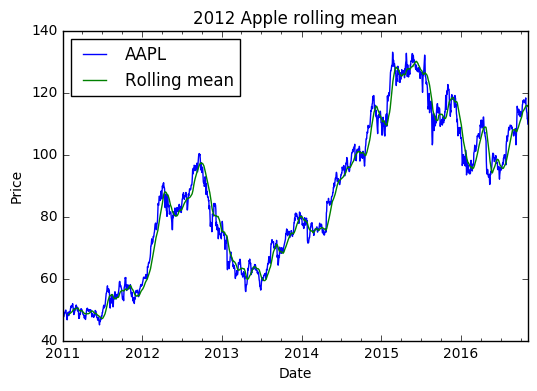

In [1088]:
def plot_data(df, title='Stock Prices', ylabel="Price", xlabel="Date"):
    """Plot stock prices with a custom title and meaningful axis labels."""
    ax = df.plot(title=title, fontsize=12)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()
    
    
def test_run():
    # Read data
    dates = pd.date_range('2011-01-01', '2016-12-31')
    symbols = ['AAPL']
    df = get_data(symbols, dates, five_year_nasdaq_df)
    
    # Plot SPY data, retain matplotlib axis object
    ax = df['AAPL'].plot(title='2012 Apple rolling mean', label='AAPL')
    
    # Compute the rolling mean using a 20 day window
    rm_AAPL = pd.rolling_mean(df['AAPL'], window=20)
    
    # Add rolling mean to same plot
    rm_AAPL.plot(label='Rolling mean', ax=ax)
    
    # Add axis labels and legend
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend(loc='upper left')
    plt.show()
    
    
    
if __name__ == "__main__":
    test_run()

In [763]:
dates = pd.date_range('2011-01-22', '2011-04-26')
get_data(['AAPL', 'ACET'], dates, five_year_nasdaq_df).head()

,AAPL,ACET
2011-01-24,48.2071,9.02
2011-01-25,48.7714,9.07
2011-01-26,49.1214,8.98
2011-01-27,49.0300,9.03
2011-01-28,48.0143,8.57


<h2>CELLS FROM HERE TO GOAL WILL BE REMOVED AFTER NEXT COMMIT</h2>

In [870]:
len(filings[filings.index > '20110000'])

621710

In [ ]:
tickers_cik = pd.DataFrame(tickers_cik_in_both, columns=['cik', 'symbol'])
symbol_to_filings = pd.merge(left=filings, right=tickers_cik[tickers_cik['cik'].isin(
            tickers_cik['cik'].unique())], left_on='cik', right_on='cik')
#symbol_to_filings = pd.DataFrame(symbol_to_filings, columns=['cik', 'symbol', 'company_name', 'type', 'date', 'path'])

In [877]:
t_fil = sql_to_df('select * from filings where cik in {} limit 5;'.format(tuple(tickers_cik_in_both['cik'])), engine.connect())


In [880]:
t_fil[t_fil['date'] > '19950927']

,cik,company_name,type,date,path
1,2034,ACETO CORP,10-K,19960927,edgar/data/2034/0000002034-96-000004.txt
2,2034,ACETO CORP,10-K,19970929,edgar/data/2034/0000002034-97-000005.txt
3,2034,ACETO CORP,10-K,19980929,edgar/data/2034/0000002034-98-000003.txt
4,2034,ACETO CORP,10-K,19990928,edgar/data/2034/0000002034-99-000008.txt


<h2>Goal:</h2>

<p>
The goal is to find out which forms affect stock price.  My idea is to to look at the price the day before and day of a form being filed.  To do this start with one stock, make it work then switch to many stocks.  To meausre the change in price to the the mean error (standard deviation).
</p>

In [916]:
first_day = 70
second_day = 56
change = pow(second_day - first_day, 2)


In [920]:
mean = five_year_nasdaq_df[five_year_nasdaq_df['Symbol'] =='AAME']['Close'].mean()
std = five_year_nasdaq_df[five_year_nasdaq_df['Symbol'] =='AAME']['Close'].std()

In [931]:
five_year_nasdaq_df[five_year_nasdaq_df['Symbol'] =='AAME']['Close'][0:10]

2011-01-03    2.06
2011-01-04    2.07
2011-01-05    2.06
2011-01-06    2.10
2011-01-07    2.06
2011-01-10    2.06
2011-01-11    1.98
2011-01-12    2.00
2011-01-13    2.00
2011-01-14    2.19
Name: Close, dtype: float64